## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [3]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 10.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [1]:
import os
import gc
import time
import random
import warnings

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler

import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
from warmup_scheduler import GradualWarmupScheduler

from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score, fbeta_score

# GPU関連の設定
warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True # type: ignore
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## config

In [2]:
class CFG:
    # ============== comp exp name =============
    comp_name ='vesuvius'

    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b0'

    in_chans = 6 # 65
    mid = 32 ## 65 // 2
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15 # 30

    warmup_factor = 10
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    outputs_path = f'/kaggle/working/outputs/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + f'{comp_name}-models/'
    
    figures_dir = outputs_path + 'figures/'
    
    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


## helper

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

    
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

        
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    
    if mode == 'train':
        make_dirs(cfg)

In [5]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')




-------- exp_info -----------------


## image, mask

In [9]:
def use_idxs(): #TODO: インクが含まれている箇所の分析
    mid = CFG.mid
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)
    return idxs

def read_image_label_mask(fragment_id):

    images = []

    idxs = use_idxs()

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)
        images.append(image)
        
    images = np.stack(images, axis=2)

    label = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    label = np.pad(label, [(0, pad0), (0, pad1)], constant_values=0)
    label = label.astype('float32')
    label /= 255.0
    
    return images, label

In [10]:
def get_train_valid_dataset():
    train_images = []
    train_labels = []

    valid_images = []
    valid_labels = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, label = read_image_label_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))
        
        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
        
                if fragment_id == CFG.valid_id: # TODO:validation strategy 
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_labels.append(label[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_labels.append(label[y1:y2, x1:x2, None])

    return train_images, train_labels, valid_images, valid_labels, valid_xyxys

In [11]:
train_images, train_labels, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset()
valid_xyxys = np.stack(valid_xyxys)

100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


In [12]:
print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")


len(train_images) = 14454
train_images[0].shape = (224, 224, 6)
train_labels[0].shape = (224, 224, 1)
len(valid_images) = 4161
valid_images[0].shape = (224, 224, 6)
valid_labels[0].shape = (224, 224, 1)



In [13]:
valid_xyxys

array([[   0,    0,  224,  224],
       [ 112,    0,  336,  224],
       [ 224,    0,  448,  224],
       ...,
       [6048, 8064, 6272, 8288],
       [6160, 8064, 6384, 8288],
       [6272, 8064, 6496, 8288]])

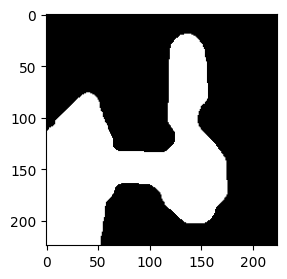

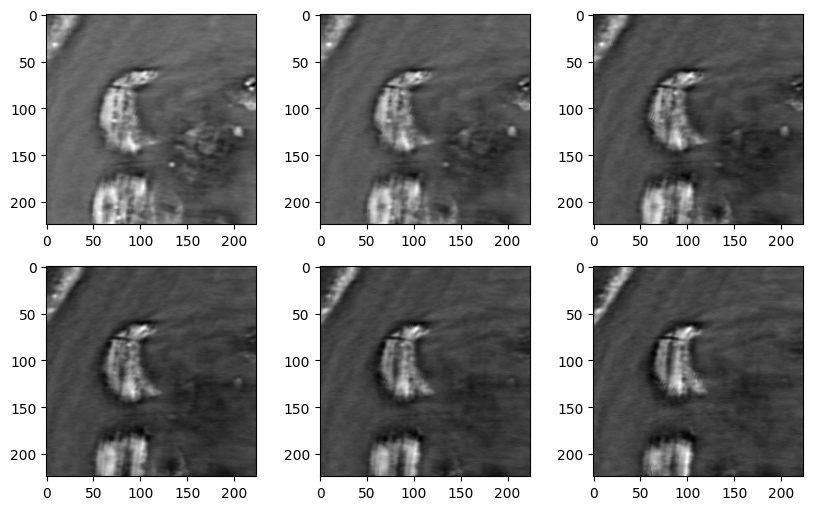

In [14]:
def visualize(id):
    plt.figure(figsize=(4, 3))
    plt.imshow(train_labels[id], cmap="gray")
    
    plt.figure(figsize=(10, 6))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(train_images[id][:, :, i], cmap="gray")
visualize(893)
    

## dataset

In [15]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [16]:
train_dataset = CustomDataset(
    train_images, CFG, labels=train_labels, transform=get_transforms(data='train', cfg=CFG))

valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_labels, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [17]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

21091

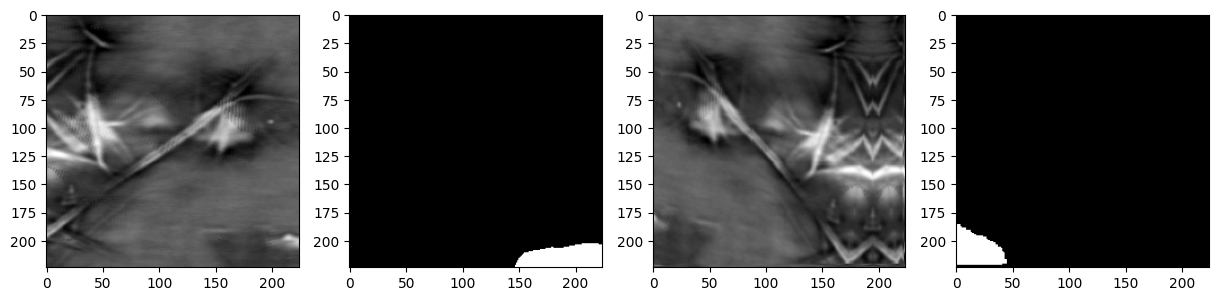

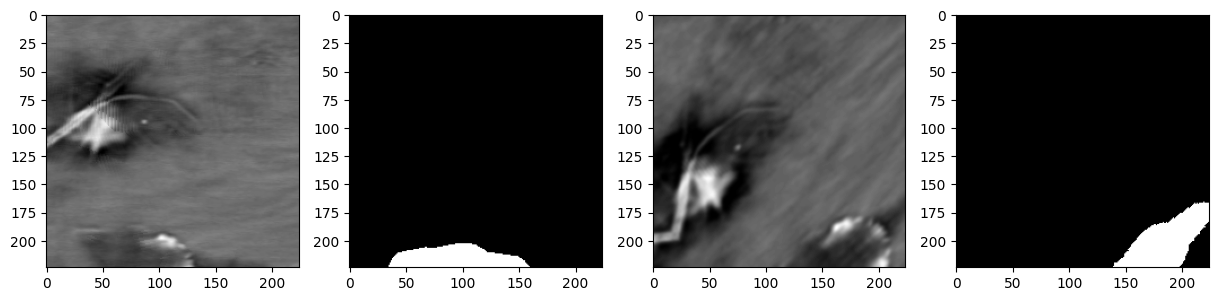

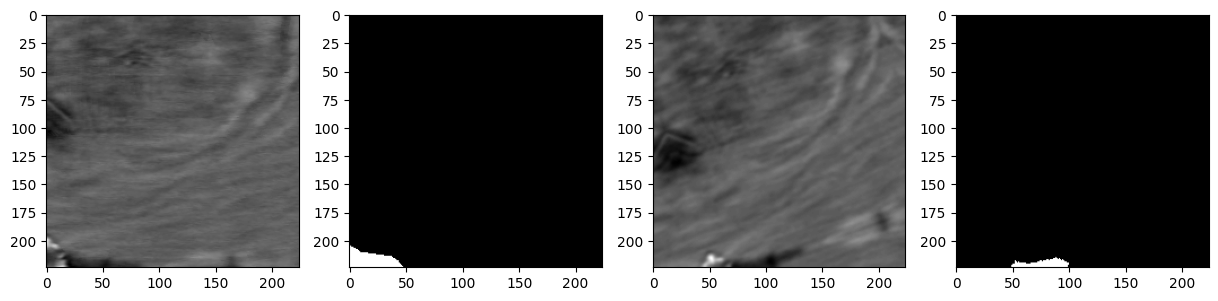

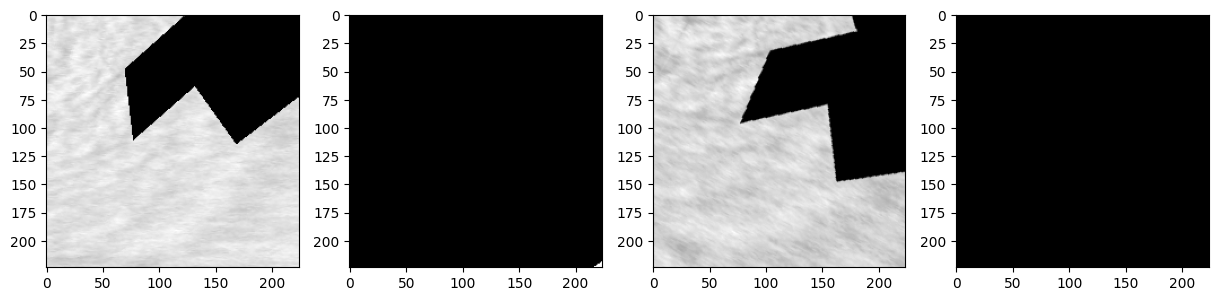

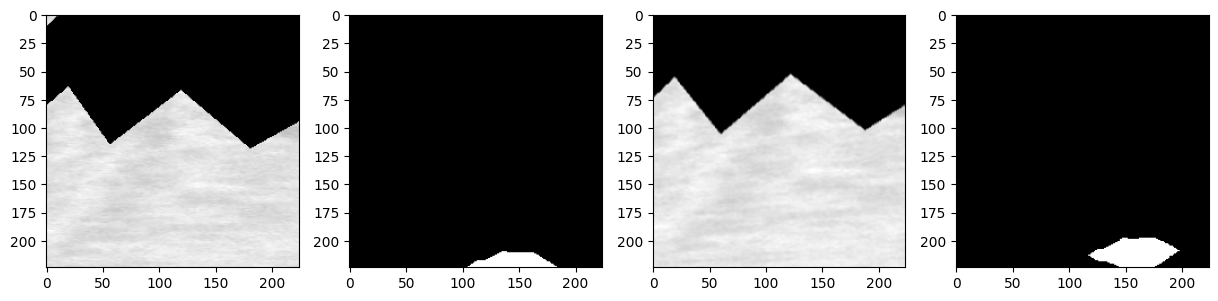

In [18]:
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, label = plot_dataset[i]
    data = transform(image=image, mask=label)
    aug_image = data['image']
    aug_label = data['mask']

    if label.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(label, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_label, cmap="gray")
    
    plot_count += 1
    if plot_count == 5:
        break

del plot_dataset
gc.collect()

## model

In [19]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name: ', cfg.model_name)
    print('backbone: ', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

## scheduler

In [20]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [21]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name:  Unet
backbone:  efficientnet-b0


## loss

In [22]:
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    return BCELoss(y_pred, y_true)

## train, val

In [27]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_label_gt):
    label_pred = np.zeros(valid_label_gt.shape)
    label_count = np.zeros(valid_label_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            label_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            label_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    label_pred /= label_count
    return losses.avg, label_pred

## metrics

In [28]:
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(label, label_pred):
    label = label.astype(int).flatten()
    label_pred = label_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        dice = fbeta_numpy(label, (label_pred >= th).astype(int), beta=0.5)
        # print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(label_gt, label_pred):
    best_dice, best_th = calc_fbeta(label_gt, label_pred)

    return best_dice, best_th

## main

In [29]:
fragment_id = CFG.valid_id

valid_label_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_label_gt = valid_label_gt / 255
pad0 = (CFG.tile_size - valid_label_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_label_gt.shape[1] % CFG.tile_size)
valid_label_gt = np.pad(valid_label_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [30]:
fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_train_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, label_pred = valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_label_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_label_gt, label_pred)

    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    print()

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score
    
    if update_best:
        best_loss = avg_val_loss
        best_score = score
        
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': label_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

100%|██████████| 131/131 [00:03<00:00, 33.10it/s]
best_th: 0.25, fbeta: 0.4513914060940678
Epoch 1 - avg_train_loss: 0.2749  avg_val_loss: 0.2468  time: 46s
Epoch 1 - avgScore: 0.4514
Epoch 1 - Save Best Loss: 0.2468 Model
Epoch 1 - Save Best Score: 0.4514 Model


100%|██████████| 131/131 [00:03<00:00, 32.88it/s]
best_th: 0.4, fbeta: 0.4570007109606469
Epoch 2 - avg_train_loss: 0.2545  avg_val_loss: 0.2383  time: 47s
Epoch 2 - avgScore: 0.4570
Epoch 2 - Save Best Loss: 0.2383 Model
Epoch 2 - Save Best Score: 0.4570 Model


100%|██████████| 131/131 [00:03<00:00, 33.36it/s]
best_th: 0.5, fbeta: 0.470888898776299
Epoch 3 - avg_train_loss: 0.2532  avg_val_loss: 0.2454  time: 46s
Epoch 3 - avgScore: 0.4709
Epoch 3 - Save Best Loss: 0.2454 Model
Epoch 3 - Save Best Score: 0.4709 Model


100%|██████████| 131/131 [00:03<00:00, 33.69it/s]
best_th: 0.4, fbeta: 0.47416030375028084
Epoch 4 - avg_train_loss: 0.2430  avg_val_loss: 0.2414  time: 46s
Epoch 4 - avgScore: 0.4742
Epoch 4 - Save Best Loss: 0.2414 Model
Epoch 4 - Save Best Score: 0.4742 Model


100%|██████████| 131/131 [00:03<00:00, 33.11it/s]
best_th: 0.25, fbeta: 0.4249106694920961
Epoch 5 - avg_train_loss: 0.2355  avg_val_loss: 0.2611  time: 46s
Epoch 5 - avgScore: 0.4249
100%|██████████| 131/131 [00:03<00:00, 32.90it/s]
best_th: 0.35, fbeta: 0.47646940198107846
Epoch 6 - avg_train_loss: 0.2291  avg_val_loss: 0.2494  time: 46s
Epoch 6 - avgScore: 0.4765
Epoch 6 - Save Best Loss: 0.2494 Model
Epoch 6 - Save Best Score: 0.4765 Model


100%|██████████| 131/131 [00:03<00:00, 32.90it/s]
best_th: 0.3, fbeta: 0.440752857909297
Epoch 7 - avg_train_loss: 0.2197  avg_val_loss: 0.2520  time: 47s
Epoch 7 - avgScore: 0.4408
100%|██████████| 131/131 [00:03<00:00, 32.90it/s]
best_th: 0.4, fbeta: 0.47951795328435953
Epoch 8 - avg_train_loss: 0.2152  avg_val_loss: 0.2338  time: 46s
Epoch 8 - avgScore: 0.4795
Epoch 8 - Save Best Loss: 0.2338 Model
Epoch 8 - Save Best Score: 0.4795 Model


100%|██████████| 131/131 [00:03<00:00, 32.84it/s]
best_th: 0.4, fbeta: 0.48202998515069706
Epoch 9 - avg_train_loss: 0.2112  avg_val_loss: 0.2373  time: 47s
Epoch 9 - avgScore: 0.4820
Epoch 9 - Save Best Loss: 0.2373 Model
Epoch 9 - Save Best Score: 0.4820 Model


100%|██████████| 131/131 [00:04<00:00, 32.55it/s]
best_th: 0.45, fbeta: 0.505473461399859
Epoch 10 - avg_train_loss: 0.2044  avg_val_loss: 0.2516  time: 46s
Epoch 10 - avgScore: 0.5055
Epoch 10 - Save Best Loss: 0.2516 Model
Epoch 10 - Save Best Score: 0.5055 Model


100%|██████████| 131/131 [00:03<00:00, 33.41it/s]
best_th: 0.5, fbeta: 0.47671105051336354
Epoch 11 - avg_train_loss: 0.1987  avg_val_loss: 0.2596  time: 47s
Epoch 11 - avgScore: 0.4767
100%|██████████| 131/131 [00:04<00:00, 32.71it/s]
best_th: 0.3, fbeta: 0.49155346803659256
Epoch 12 - avg_train_loss: 0.1951  avg_val_loss: 0.2707  time: 47s
Epoch 12 - avgScore: 0.4916
100%|██████████| 131/131 [00:03<00:00, 33.57it/s]
best_th: 0.35, fbeta: 0.4961579243764429
Epoch 13 - avg_train_loss: 0.1943  avg_val_loss: 0.2643  time: 46s
Epoch 13 - avgScore: 0.4962
100%|██████████| 131/131 [00:03<00:00, 33.22it/s]
best_th: 0.4, fbeta: 0.5067057960438548
Epoch 14 - avg_train_loss: 0.1894  avg_val_loss: 0.2750  time: 46s
Epoch 14 - avgScore: 0.5067
Epoch 14 - Save Best Loss: 0.2750 Model
Epoch 14 - Save Best Score: 0.5067 Model


100%|██████████| 131/131 [00:04<00:00, 32.57it/s]
best_th: 0.3, fbeta: 0.4874656317318356
Epoch 15 - avg_train_loss: 0.1883  avg_val_loss: 0.2763  time: 46s
Epoch 15 - avgScore: 0.4875


In [36]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

label_pred = check_point['preds']

best_dice, best_th  = calc_fbeta(valid_label_gt, label_pred)

best_th: 0.4, fbeta: 0.5067057960438548


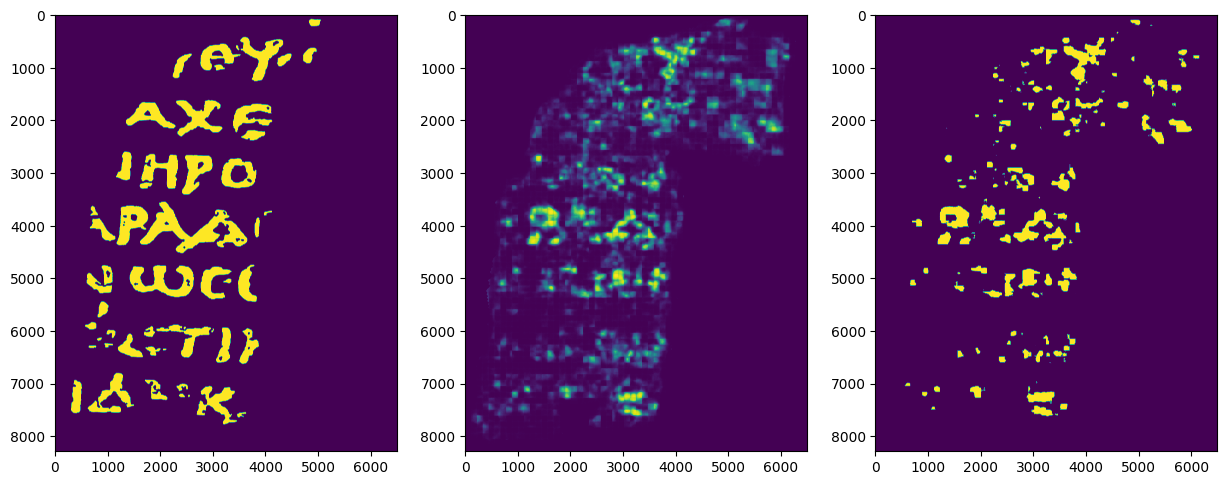

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_label_gt)
axes[1].imshow(label_pred)
axes[2].imshow((label_pred>=best_th).astype(int))

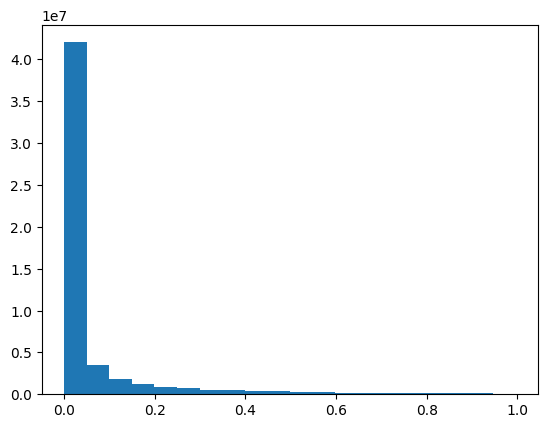

In [35]:
plt.hist(label_pred.flatten(), bins=20);